In [1]:
import numpy as np

from modules.helper_functions_tsp import (find_problem_size, 
                                          cost_fn_fact, 
                                          hot_start, 
                                          convert_bit_string_to_cycle, 
                                          hot_start_list_to_string,
                                          update_parameters_using_gradient, 
                                          define_parameters, 
                                          create_initial_rotations,
                                          bind_weights, 
                                          vqc_circuit, 
                                          cost_func_evaluate, 
                                          find_run_stats,
                                          find_distances_array
                                          )

from modules.graph_functions import parameter_graph, cost_graph_multi
from classes.DataLogger import DataLogger

import copy
import time

from pathlib import Path

In [2]:
from modules.config import (LOCATIONS, 
                            ROTATIONS, 
                            SHOTS,
                            MODE, 
                            ITERATIONS, 
                            PRINT_FREQUENCY, 
                            GRAY, 
                            HOT_START,
                            VERBOSE, 
                            GRADIENT_TYPE, 
                            S, 
                            ETA, 
                            ALPHA, 
                            GAMMA, 
                            C, 
                            BIG_A,    
                            CHANGE_EACH_PARAMETER, 
                            PLOT_PARAMETER_EVALUATION,
                            SLICES, 
                            DECODING_FORMULATION
                            )

Instantiate data logger - this will create a graph folder path


In [3]:
datalogger = DataLogger()
datalogger.create_graph_path()

Data logger instantiated.  Run ID: 20250321-17-54-30
Folder graph_sub_path = graphs\20250321-17-54-30 is created for graphs


Read in the control file
The executions are controlled by a CSV parameter file in the control directory

From the number of locations visited find the qubits and longest binary string.

In [4]:
qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')

There are 8 qubits needed for 6 locations in the original formulation.


Data sources are held locally to avoid downstream dependencies.  Read the data, and print out the filename and best distance held in the data.  Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [5]:
distance_array, best_dist = find_distances_array(LOCATIONS, print_comments=True)

Reading distance data
Data will be read from filename networks\sim_dist_6_locs.txt.
It is known that the shortest distance is 241.0


Define the VQC circuits with appropriate parameters, and draw the circuit.

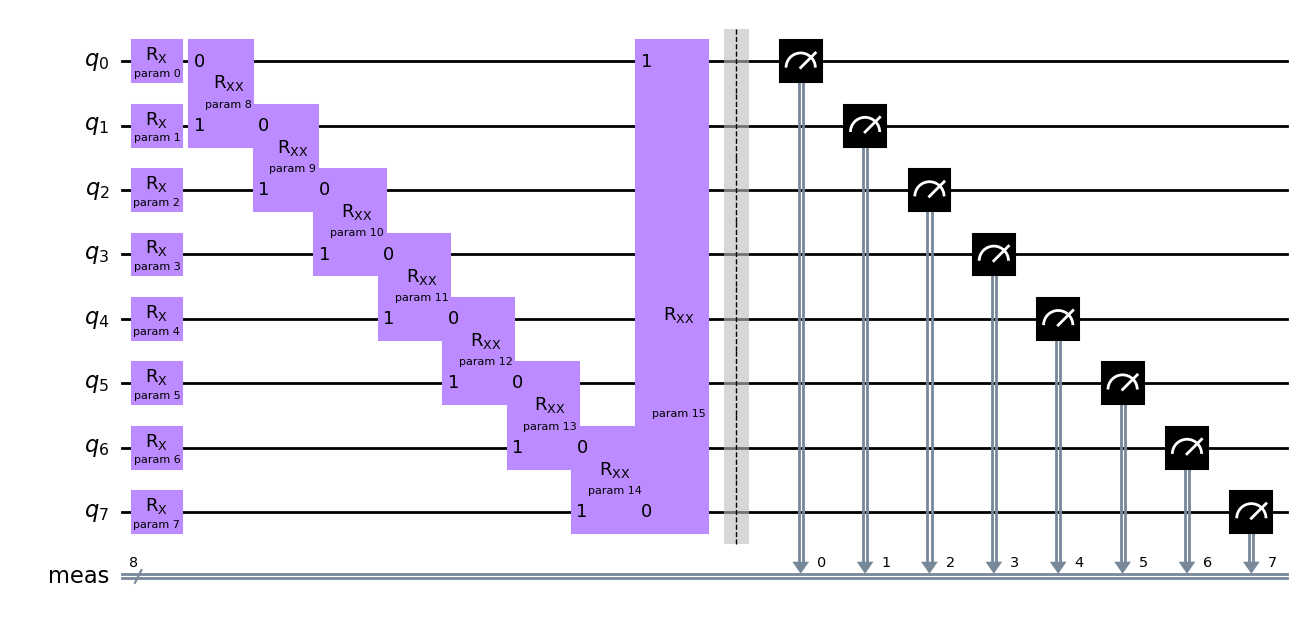

In [6]:
params = define_parameters(qubits, MODE)
qc = vqc_circuit(qubits, params, MODE)
filename = Path.joinpath(datalogger.graph_sub_path, f'initial_unbound_circuit.png')
qc.draw("mpl", style="clifford", filename=filename )

In [7]:
cost_fn = cost_fn_fact(LOCATIONS,distance_array, GRAY, method = DECODING_FORMULATION)

Iterate over the control parameters and do one experiment for each one of them.

Create random initial rotations, and bind these to the parameters in a new circuit `bc`.

The hot start location list is [0, 3, 5, 4, 1, 2]
This is equivalent to a binary list: [0, 1, 1, 1, 0, 1, 1, 0]
The hot start distance is 279.6, compared to a best distance of 241.0.
The initial parameters (weights) are [0.         3.14159265 3.14159265 0.         3.14159265 3.14159265
 3.14159265 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


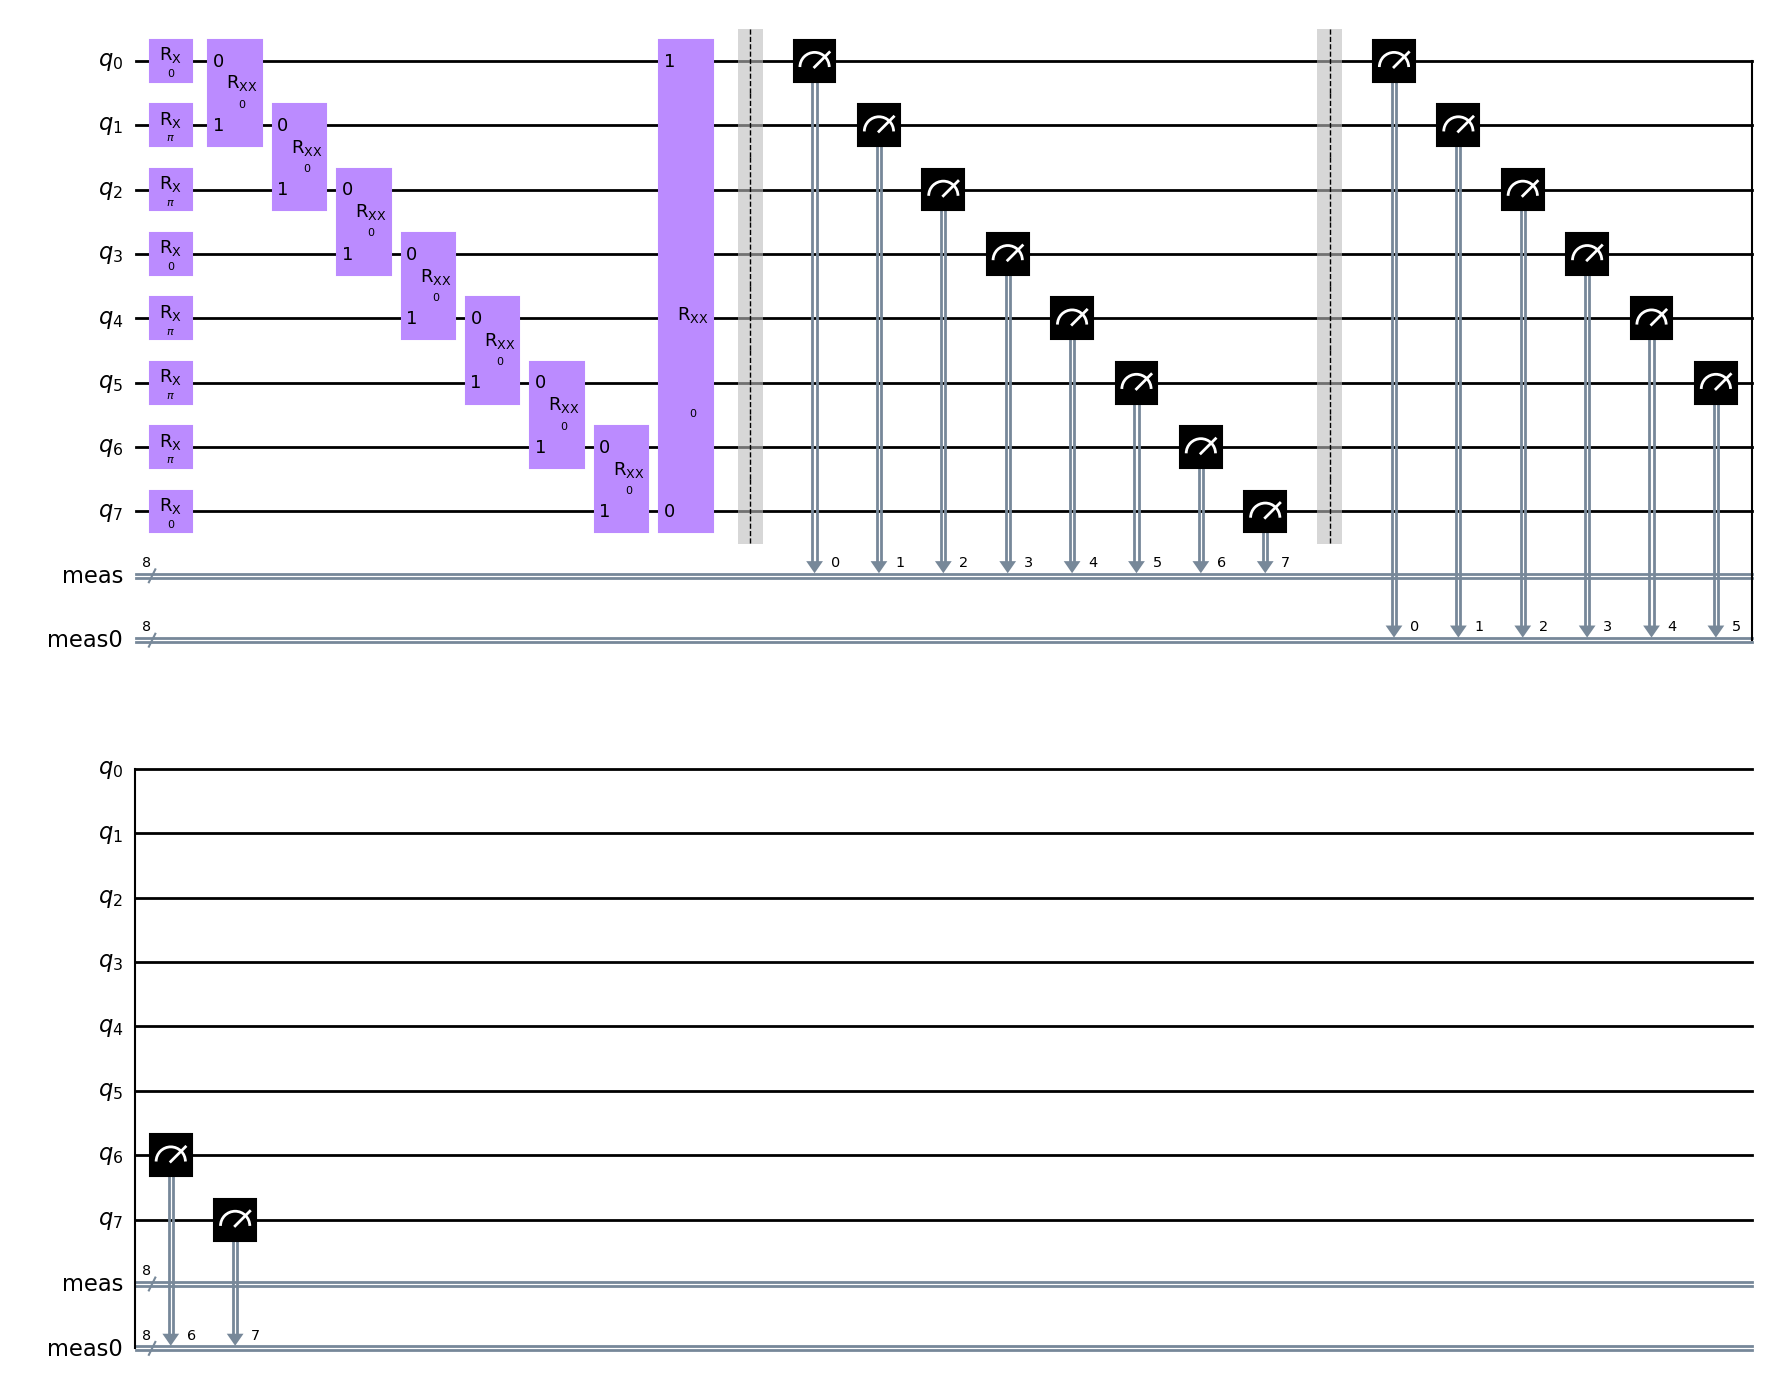

In [8]:
if HOT_START:
    hot_start_list = hot_start(distance_array, LOCATIONS)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY, DECODING_FORMULATION)
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    distance = cost_fn(bin_hot_start_list)
    print(f'The hot start distance is {distance}, compared to a best distance of {best_dist}.')
    init_rots = create_initial_rotations(qubits, MODE, bin_hot_start_list, HOT_START)
else:
    init_rots = create_initial_rotations(qubits, MODE)
print(f'The initial parameters (weights) are {init_rots}')
bc = bind_weights(params, init_rots, qc)
bc.measure_all()
filename = Path.joinpath(datalogger.graph_sub_path, f'initial_bound_circuit.png')
bc.draw("mpl", style="clifford", filename=filename )

In [9]:
cost_start, lowest_to_date, _ = cost_func_evaluate(cost_fn, bc, shots=SHOTS, average_slice=SLICES[0], verbose=VERBOSE)
print(f'For the starting circuit the average cost is {cost_start:.1f} and the lowest cost is {lowest_to_date:.1f}')

For the starting circuit the average cost is 279.6 and the lowest cost is 279.6


Next we test the impact of varying each parameter in turn on the average cost.

In [10]:
#only run for first slice.
if CHANGE_EACH_PARAMETER:
    average_slice = SLICES[0]
    param_values = np.array([(i * 2 * np.pi) / (ROTATIONS-1) for i in range(ROTATIONS)])
    cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
    if VERBOSE:
        print(f'init_rots = {init_rots}')
    #need deep copy in case init_rots is changed
    for i in range(2*qubits):
        rots = copy.deepcopy(init_rots)
        if VERBOSE:
            print(f'Processing parameter {i}')
            print(f'rots = {rots}, init_rots = {init_rots}')
        cost_list, lowest_list, sliced_cost_list  = [], [], []
        for angle in param_values:
            rots[i] = angle
            bc = bind_weights(params, rots, qc)
            sliced_cost, _ , _ = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=average_slice, verbose=VERBOSE)
            cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=1, verbose=VERBOSE)
            route_list = convert_bit_string_to_cycle(lowest_energy_bit_string, LOCATIONS, gray=GRAY, method=DECODING_FORMULATION)
            cost_list.append(cost)
            lowest_list.append(lowest)
            sliced_cost_list.append(sliced_cost)
            if VERBOSE:
                print(f'For angle {angle} the cost is {cost}, the lowest cost found is {lowest}')
                print(f'The full parameter vector is {rots}')
                print(f'the lowest energy bit string is {lowest_energy_bit_string} and this corresponds to a route of {route_list}')
                print(f'The average is {cost} without slicing, and {sliced_cost} with slicing')
        cost_list_all.append(cost_list)
        lowest_list_all.append(lowest_list)     
        sliced_cost_list_all.append(sliced_cost_list)
    items, hits, misses = cost_fn.report_cache_stats()
    cost_fn.clear_cache() #need to clear cache so statistics are not cumulative

In [11]:
if CHANGE_EACH_PARAMETER:
    filename = Path.joinpath(datalogger.graph_sub_path,'Parameter_values')
    main_title = f'Av and lowest energy (distance) found by changing each parameter in turn with slices = {SLICES[0]}'
    sub_title = 'Parameter '
    x_label = 'Gate rotation in Radians'
    param_names = [i for i in range(2*qubits)]
    cost_graph_multi(filename, param_names, param_values, 
                    cost_list_all, lowest_list_all, sliced_cost_list_all, 
                    best_dist, main_title, sub_title, x_label)

In [12]:
if PLOT_PARAMETER_EVALUATION:
    average_slice = SLICES[0]
    #only do for one slice
    index_l, sliced_l, lowest_l, gradient_l, average_l, parameter_l = \
    update_parameters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                    print_frequency=PRINT_FREQUENCY, params=params,
                                    rots=init_rots,  
                                    cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                    eta=ETA, average_slice=average_slice, gray=GRAY, 
                                    verbose=VERBOSE, gradient_type=GRADIENT_TYPE,
                                    alpha=ALPHA, gamma=GAMMA, c=C, big_a=BIG_A,
                                    method=DECODING_FORMULATION
                                    )
    cost_fn.print_cache_stats
    cost_fn.clear_cache() #need to clear cache so statistics are not cumulative

For iteration 0 using the best 100 percent of the results
The average cost from the sample is 279.600 and the top-sliced average of the best results is 279.600
The lowest cost from the sample is 279.600
The lowest cost to date is 279.600 corresponding to bit string [0, 1, 1, 1, 0, 1, 1, 0] 
and route [0, 3, 5, 4, 1, 2]
For iteration 20 using the best 100 percent of the results
The average cost from the sample is 279.600 and the top-sliced average of the best results is 279.674
The lowest cost from the sample is 279.600
The lowest cost to date is 279.600 corresponding to bit string [0, 1, 1, 1, 0, 1, 1, 0] 
and route [0, 3, 5, 4, 1, 2]
For iteration 40 using the best 100 percent of the results
The average cost from the sample is 279.748 and the top-sliced average of the best results is 279.966
The lowest cost from the sample is 279.600
The lowest cost to date is 279.600 corresponding to bit string [0, 1, 1, 1, 0, 1, 1, 0] 
and route [0, 3, 5, 4, 1, 2]
For iteration 60 using the best 100

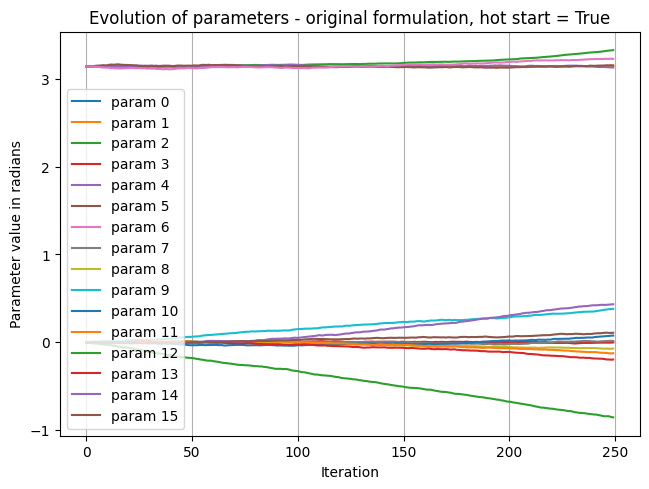

In [13]:
if PLOT_PARAMETER_EVALUATION:
    legend = [params[i].name for i in range(len(params))] 
    short_title = 'Evolution of parameters -'
    full_title = short_title + f' {DECODING_FORMULATION} formulation, hot start = {HOT_START}'
    filename = Path.joinpath(datalogger.graph_sub_path,short_title)
    parameter_graph(filename, full_title, index_l, parameter_l, legend)

Do one run and time

In [14]:
t0 = time.time()
av_cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
rots = copy.deepcopy(init_rots)
for slice in SLICES:
    index_list, sliced_list, lowest_list, _ , average_list, _ = \
    update_parameters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                    print_frequency=PRINT_FREQUENCY, params=params,
                                    rots=rots,  
                                    cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                    eta=ETA, average_slice=slice, gray=GRAY, 
                                    verbose=VERBOSE, gradient_type=GRADIENT_TYPE,
                                    alpha=ALPHA, gamma=GAMMA, c=C,
                                    method=DECODING_FORMULATION)
    av_cost_list_all.append(average_list)
    lowest_list_all.append(lowest_list)
    sliced_cost_list_all.append(sliced_list)
    best_run_distance, iteration = find_run_stats(lowest_list)
    print(f'With a slice of {slice} the best distance found was {best_run_distance} at iteration {iteration}')
    print(f'This is compared to the best distance of {best_dist}, giving a quality of {best_dist/best_run_distance:.1%}')
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
        

For iteration 0 using the best 100 percent of the results
The average cost from the sample is 279.600 and the top-sliced average of the best results is 279.600
The lowest cost from the sample is 279.600
The lowest cost to date is 279.600 corresponding to bit string [0, 1, 1, 1, 0, 1, 1, 0] 
and route [0, 3, 5, 4, 1, 2]
For iteration 20 using the best 100 percent of the results
The average cost from the sample is 279.637 and the top-sliced average of the best results is 279.637
The lowest cost from the sample is 279.600
The lowest cost to date is 279.600 corresponding to bit string [0, 1, 1, 1, 0, 1, 1, 0] 
and route [0, 3, 5, 4, 1, 2]
For iteration 40 using the best 100 percent of the results
The average cost from the sample is 279.892 and the top-sliced average of the best results is 280.003
The lowest cost from the sample is 279.600
The lowest cost to date is 279.600 corresponding to bit string [0, 1, 1, 1, 0, 1, 1, 0] 
and route [0, 3, 5, 4, 1, 2]
For iteration 60 using the best 100

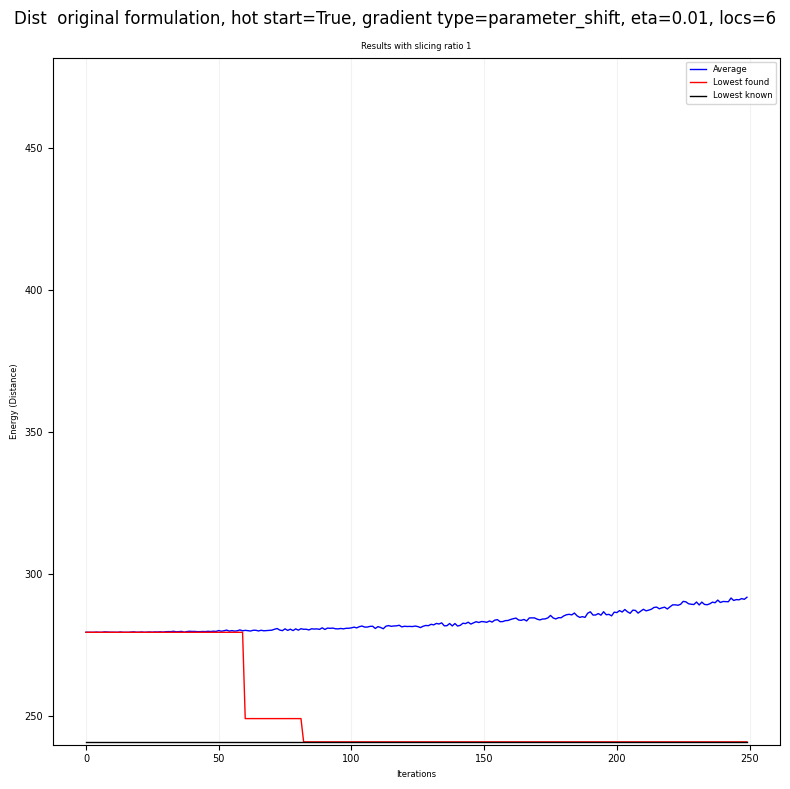

In [15]:
#short_title = 'Dist. by slicing ratio'
short_title = 'Dist '
full_title = short_title + f' {DECODING_FORMULATION} formulation, hot start={HOT_START}, '
full_title = full_title + f'gradient type={GRADIENT_TYPE}, eta={ETA}, locs={LOCATIONS}'
filename = Path.joinpath(datalogger.graph_sub_path,short_title)
sub_title = 'Results with slicing ratio '
x_label = 'Iterations'
if SLICES  == [1]:
    plot_slices = False
else:
    plot_slices = True

cost_graph_multi(filename, 
                 SLICES, 
                 index_list, 
                 av_cost_list_all, 
                 lowest_list_all, 
                 sliced_cost_list_all, 
                 best_dist, 
                 full_title, 
                 sub_title,
                 x_label,
                 plot_slices=plot_slices,
                )
cost_fn.print_cache_stats
cost_fn.clear_cache() #need to clear cache so statistics are not cumulative